**Секція 1. Логістична регресія з нуля.**

Будемо крок за кроком будувати модель лог регресії з нуля для передбачення, чи буде врожай більше за 80 яблук (задача подібна до лекційної, але на класифікацію).

Давайте нагадаємо основні формули для логістичної регресії.

### Функція гіпотези - обчислення передбачення у логістичній регресії:

$$
\hat{y} = \sigma(x W^T + b) = \frac{1}{1 + e^{-(x W^T + b)}}
$$

Де:
- $ \hat{y} $ — це ймовірність "позитивного" класу.
- $ x $ — це вектор (або матриця для набору прикладів) вхідних даних.
- $ W $ — це вектор (або матриця) вагових коефіцієнтів моделі.
- $ b $ — це зміщення (bias).
- $ \sigma(z) $ — це сигмоїдна функція активації.

### Як обчислюється сигмоїдна функція:

Сигмоїдна функція $ \sigma(z) $ має вигляд:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Ця функція перетворює будь-яке дійсне значення $ z $ в інтервал від 0 до 1, що дозволяє інтерпретувати вихід як ймовірність для логістичної регресії.

### Формула функції втрат для логістичної регресії (бінарна крос-ентропія):

Функція втрат крос-ентропії оцінює, наскільки добре модель передбачає класи, порівнюючи передбачені ймовірності $ \hat{y} $ із справжніми мітками $ y $. Формула наступна:

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

Де:
- $ y $ — це справжнє значення (мітка класу, 0 або 1).
- $ \hat{y} $ — це передбачене значення (ймовірність).



1.
Тут вже наведений код для ініціювання набору даних в форматі numpy. Перетворіть `inputs`, `targets` на `torch` тензори. Виведіть результат на екран.

In [318]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func

In [319]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

In [320]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


2. Ініціюйте ваги `w`, `b` для моделі логістичної регресії потрібної форми зважаючи на розмірності даних випадковими значеннями з нормального розподілу. Лишаю тут код для фіксації `random_seed`.

In [321]:
# Weights and biases
torch.random.manual_seed(1)
w = torch.randn(inputs.shape[1], requires_grad=True)
b = torch.randn(1, requires_grad=True)
print(w)
print(b)

tensor([0.6614, 0.2669, 0.0617], requires_grad=True)
tensor([0.6213], requires_grad=True)


3. Напишіть функцію `model`, яка буде обчислювати функцію гіпотези в логістичній регресії і дозволяти робити передбачення на основі введеного рядка даних і коефіцієнтів в змінних `w`, `b`.

  **Важливий момент**, що функція `model` робить обчислення на `torch.tensors`, тож для математичних обчислень використовуємо фукнціонал `torch`, наприклад:
  - обчсилення $e^x$: `torch.exp(x)`
  - обчсилення $log(x)$: `torch.log(x)`
  - обчислення середнього значення вектору `x`: `torch.mean(x)`

  Використайте функцію `model` для обчислення передбачень з поточними значеннями `w`, `b`.Виведіть результат обчислень на екран.

  Проаналізуйте передбачення. Чи не викликають вони у вас підозр? І якщо викликають, то чим це може бути зумовлено?

In [322]:
def model(X, w, b):
  z = X @ w.T + b
  return 1 / (1 + torch.exp(-z))

In [323]:
target_pred_proba = model(inputs, w, b)
target_pred_proba

tensor([1., 1., 1., 1., 1.], grad_fn=<MulBackward0>)

Підозріло виглядає те, що всі передбачення дорівнюють рівно 1, хоча ми мали б отримати імовірності від 0 до 1.

4. Напишіть функцію `binary_cross_entropy`, яка приймає на вхід передбачення моделі `predicted_probs` та справжні мітки в даних `true_labels` і обчислює значення втрат (loss)  за формулою бінарної крос-ентропії для кожного екземпляра та вертає середні втрати по всьому набору даних.
  Використайте функцію `binary_cross_entropy` для обчислення втрат для поточних передбачень моделі.

In [324]:
def binary_cross_entropy(predicted_probs, true_labels):
    epsilon = 1e-7
    predicted_probs = torch.clamp(predicted_probs, epsilon, 1 - epsilon)  # Ensure probabilities are between epsilon and 1-epsilon
    return -torch.mean(true_labels * torch.log(predicted_probs) + (1 - true_labels) * torch.log(1 - predicted_probs))

In [325]:
loss = binary_cross_entropy(target_pred_proba, targets)
loss

tensor(6.3770, grad_fn=<NegBackward0>)

5. Зробіть зворотнє поширення помилки і виведіть градієнти за параметрами `w`, `b`. Проаналізуйте їх значення. Як гадаєте, чому вони саме такі?

In [326]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([0., 0., 0.])
tensor([0.])


Градієнти дорівнюють 0.

**Що сталось?**

В цій задачі, коли ми ініціювали значення випадковими значеннями з нормального розподілу, насправді ці значення не були дуже гарними стартовими значеннями і привели до того, що градієнти стали дуже малими або навіть рівними нулю (це призводить до того, що градієнти "зникають"), і відповідно при оновленні ваг у нас не буде нічого змінюватись. Це називається `gradient vanishing`. Це відбувається через **насичення сигмоїдної функції активації.**

У нашій задачі ми використовуємо сигмоїдну функцію активації, яка має такий вигляд:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$


Коли значення $z$ дуже велике або дуже мале, сигмоїдна функція починає "насичуватись". Це означає, що для великих позитивних $z$ сигмоїда наближається до 1, а для великих негативних — до 0. В цих діапазонах градієнти починають стрімко зменшуватись і наближаються до нуля (бо градієнт - це похідна, похідна на проміжку функції, де вона паралельна осі ОХ, дорівнює 0), що робить оновлення ваг неможливим.

![](https://editor.analyticsvidhya.com/uploads/27889vaegp.png)

У логістичній регресії $ z = x \cdot w + b $. Якщо ваги $w, b$ - великі, значення $z$ також буде великим, і сигмоїда перейде в насичену область, де градієнти дуже малі.

Саме це сталося в нашій задачі, де великі випадкові значення ваг викликали насичення сигмоїдної функції. Це в свою чергу призводить до того, що під час зворотного поширення помилки (backpropagation) модель оновлює ваги дуже повільно або зовсім не оновлює. Це називається проблемою **зникнення градієнтів** (gradient vanishing problem).

**Що ж робити?**
Ініціювати ваги маленькими значеннями навколо нуля. Наприклад ми можемо просто в існуючій ініціалізації ваги розділити на 1000. Можна також використати інший спосіб ініціалізації вагів - інформація про це [тут](https://www.geeksforgeeks.org/initialize-weights-in-pytorch/).

Як це робити - показую нижче. **Виконайте код та знову обчисліть передбачення, лосс і виведіть градієнти.**

А я пишу пояснення, чому просто не зробити

```
w = torch.randn(1, 3, requires_grad=True)/1000
b = torch.randn(1, requires_grad=True)/1000
```

Нам потрібно, аби тензори вагів були листовими (leaf tensors).

1. **Що таке листовий тензор**
Листовий тензор — це тензор, який був створений користувачем безпосередньо і з якого починається обчислювальний граф. Якщо такий тензор має `requires_grad=True`, PyTorch буде відслідковувати всі операції, виконані над ним, щоб правильно обчислювати градієнти під час навчання.

2. **Чому ми використовуємо `w.data` замість звичайних операцій**
Якщо ми просто виконали б операції, такі як `(w - 0.5) / 100`, ми б отримали **новий тензор**, який вже не був би листовим тензором, оскільки ці операції створюють **новий** тензор, а не модифікують існуючий.

  Проте, щоб залишити наші тензори ваги `w` та зміщення `b` листовими і продовжити можливість відстеження градієнтів під час тренування, ми використовуємо атрибут `.data`. Цей атрибут дозволяє **виконувати операції in-place (прямо на існуючому тензорі)** без зміни самого об'єкта тензора. Отже, тензор залишається листовим, і PyTorch може коректно обчислювати його градієнти.

3. **Чому важливо залишити тензор листовим**
Якщо тензор більше не є листовим (наприклад, через проведення операцій, що створюють нові тензори), ви не зможете отримати градієнти за допомогою `w.grad` чи `b.grad` після виклику `loss.backward()`. Це може призвести до втрати можливості оновлення параметрів під час тренування моделі. В нашому випадку ми хочемо, щоб тензори `w` та `b` накопичували градієнти, тому вони повинні залишатись листовими.

**Висновок:**
Ми використовуємо `.data`, щоб виконати операції зміни значень на ваги і зміщення **in-place**, залишаючи їх листовими тензорами, які можуть накопичувати градієнти під час навчання. Це дозволяє коректно працювати механізму зворотного поширення помилки (backpropagation) і оновлювати ваги моделі.

5. Виконайте код та знову обчисліть передбачення, лосс і знайдіть градієнти та виведіть всі ці тензори на екран.

In [327]:
torch.random.manual_seed(1)
w = torch.randn(1, 3, requires_grad=True)  # Листовий тензор
b = torch.randn(1, requires_grad=True)     # Листовий тензор

# in-place операції
w.data = w.data / 1000
b.data = b.data / 1000

In [328]:
target_pred_proba = model(inputs, w, b)
target_pred_proba

tensor([[0.5174],
        [0.5220],
        [0.5244],
        [0.5204],
        [0.5190]], grad_fn=<MulBackward0>)

In [329]:
loss = binary_cross_entropy(target_pred_proba, targets)
loss

tensor(0.6829, grad_fn=<NegBackward0>)

In [330]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[ -5.4417, -18.9853, -10.0682]])
tensor([-0.0794])


6. Напишіть алгоритм градієнтного спуску, який буде навчати модель з використанням написаних раніше функцій і виконуючи оновлення ваг. Алгоритм має включати наступні кроки:

  1. Генерація прогнозів
  2. Обчислення втрат
  3. Обчислення градієнтів (gradients) loss-фукнції відносно ваг і зсувів
  4. Налаштування ваг шляхом віднімання невеликої величини, пропорційної градієнту (`learning_rate` домножений на градієнт)
  5. Скидання градієнтів на нуль

Виконайте градієнтний спуск протягом 1000 епох, обчисліть фінальні передбачення і проаналізуйте, чи вони точні?

In [331]:
def gradient_descent(X, w, b, y, lr=0.001, epochs=1000):
  for epoch in range(epochs):
    y_pred_proba = model(X, w, b)
    loss = binary_cross_entropy(y_pred_proba, y)
    loss.backward()

    with torch.no_grad():
      w.data = w.data - lr * w.grad
      b.data = b.data - lr * b.grad
      w.grad.zero_()
      b.grad.zero_()

    if epoch == 0 or epoch % 100 == 99:
      print(f'Epoch {epoch}, Loss: {loss}')

  return w, b

w, b = gradient_descent(inputs, w, b, targets)

Epoch 0, Loss: 0.6829456686973572
Epoch 99, Loss: 0.19809281826019287
Epoch 199, Loss: 0.16247422993183136
Epoch 299, Loss: 0.13817240297794342
Epoch 399, Loss: 0.11979919672012329
Epoch 499, Loss: 0.10536112636327744
Epoch 599, Loss: 0.09374729543924332
Epoch 699, Loss: 0.08423858135938644
Epoch 799, Loss: 0.076337531208992
Epoch 899, Loss: 0.06968771666288376
Epoch 999, Loss: 0.06402736902236938


In [332]:
preds = (model(inputs, w, b) > 0.5).int()
print(preds)
print(targets)

tensor([[0],
        [1],
        [1],
        [0],
        [1]], dtype=torch.int32)
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


Алгоритм досягнув високої точності з втратами 0.064.

**Секція 2. Створення лог регресії з використанням функціоналу `torch.nn`.**

Давайте повторно реалізуємо ту ж модель, використовуючи деякі вбудовані функції та класи з PyTorch.

Даних у нас буде побільше - тож, визначаємо нові масиви.

In [356]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

7. Завантажте вхідні дані та мітки в PyTorch тензори та з них створіть датасет, який поєднує вхідні дані з мітками, використовуючи клас `TensorDataset`. Виведіть перші 3 елементи в датасеті.



In [357]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
# Data normalization
inputs = (inputs - inputs.mean()) / inputs.std()

train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

(tensor([[-0.0717, -0.3106, -1.2662],
         [ 0.6451,  0.5256, -0.4300],
         [ 0.4858,  2.3573, -0.6690]]),
 tensor([[0.],
         [1.],
         [1.]]))

8. Визначте data loader з класом **DataLoader** для підготовленого датасету `train_ds`, встановіть розмір батчу на 5 та увімкніть перемішування даних для ефективного навчання моделі. Виведіть перший елемент в дата лоадері.

In [358]:
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[ 0.6451,  0.5256, -0.4300],
         [-0.0717, -0.3106, -1.2662],
         [ 0.6451,  0.5256, -0.4300],
         [ 1.0831, -1.2662, -1.5051],
         [-0.2309,  0.8442, -0.1911]]),
 tensor([[1.],
         [0.],
         [1.],
         [0.],
         [1.]])]

9. Створіть клас `LogReg` для логістичної регресії, наслідуючи модуль `torch.nn.Module` за прикладом в лекції (в частині про FeedForward мережі).

  У нас модель складається з лінійної комбінації вхідних значень і застосування фукнції сигмоїда. Тож, нейромережа буде складатись з лінійного шару `nn.Linear` і використання активації `nn.Sigmid`. У створеному класі мають бути реалізовані методи `__init__` з ініціалізацією шарів і метод `forward` для виконання прямого проходу моделі через лінійний шар і функцію активації.

  Створіть екземпляр класу `LogReg` в змінній `model`.

In [359]:
class LogReg(torch.nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)
        self.act = nn.Sigmoid() # Activation function

    # Perform the computation
    def forward(self, x):
        x = self.linear(x)
        x = self.act(x)
        return x

model = LogReg()

10. Задайте оптимізатор `Stockastic Gradient Descent` в змінній `opt` для навчання моделі логістичної регресії. А також визначіть в змінній `loss` функцію втрат `binary_cross_entropy` з модуля `torch.nn.functional` для обчислення втрат моделі. Обчисліть втрати для поточних передбачень і міток, а потім виведіть їх. Зробіть висновок, чи моделі вдалось навчитись?

In [360]:
opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn = func.binary_cross_entropy

In [361]:
loss = loss_fn(model(inputs), targets)
loss

tensor(0.9873, grad_fn=<BinaryCrossEntropyBackward0>)

Ми ще не вчили модель, а лише обчислили втрати використовуючи рандомно ініціалізовані ваги.

11. Візьміть з лекції функцію для тренування моделі з відстеженням значень втрат і навчіть щойно визначену модель на 1000 епохах. Виведіть після цього графік зміни loss, фінальні передбачення і значення таргетів.

In [362]:
def fit_return_loss(num_epochs, model, loss_fn, opt, train_dl):
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0

        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()  # Calculate gradients
            opt.step()  # Update weights
            opt.zero_grad()  # Reset gradients

            total_loss += loss.item()

        # Calculate epoch avg loss
        avg_loss = total_loss / len(train_dl)
        losses.append(avg_loss)

        if epoch == 0 or epoch % 100 == 99:
          print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}')

    return losses

In [363]:
# Train the model for 100 epochs
loss = fit_return_loss(1000, model, loss_fn, opt, train_dl)

Epoch [0/1000], Loss: 0.9386
Epoch [99/1000], Loss: 0.0666
Epoch [199/1000], Loss: 0.0359
Epoch [299/1000], Loss: 0.0246
Epoch [399/1000], Loss: 0.0187
Epoch [499/1000], Loss: 0.0150
Epoch [599/1000], Loss: 0.0126
Epoch [699/1000], Loss: 0.0108
Epoch [799/1000], Loss: 0.0095
Epoch [899/1000], Loss: 0.0084
Epoch [999/1000], Loss: 0.0076


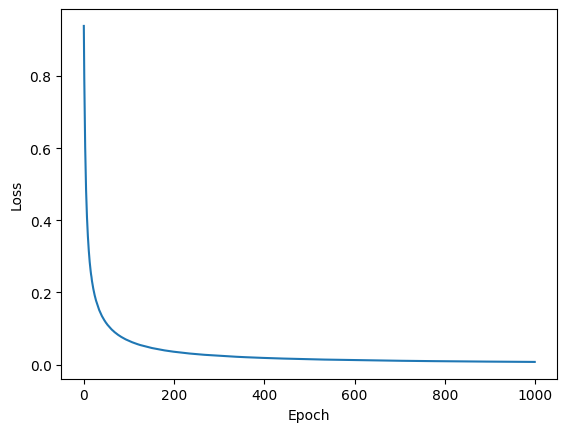

In [364]:
import matplotlib.pyplot as plt
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [365]:
preds = (model(inputs) > 0.5).int()
print(preds)
print(targets)

tensor([[0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1]], dtype=torch.int32)
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])
